# BLG-307 Yapay Zeka Sistemleri
## Genetik Algoritma ile Öğrenci Etüt Programı Optimizasyonu (Senaryo 9)

**Ad**: Gökçe Umay  
**Soyad**: SAMUR  
**Okul Numarası**: 2312721059  
**GitHub Repo Linki**: https://github.com/gumaysmr/genetik-optimizasyonu

---

## Problem Tanımı

Bu projede, bir öğrencinin sınav başarısını artırmak amacıyla haftalık etüt
saatlerini en verimli şekilde planlaması hedeflenmektedir.

Problem, genetik algoritma kullanılarak çözülmüş bir kısıtlı optimizasyon problemidir.

### Amaç Fonksiyonu
Öğrencinin başarı skoru aşağıdaki şekilde tanımlanmıştır:

y = 4x₁ + 5x₂ − 0.5x₁² − 0.2x₂²

- x₁: Matematik etüt süresi (saat)
- x₂: Fen etüt süresi (saat)

### Değişken Aralıkları
- 0 ≤ x₁ ≤ 10
- 0 ≤ x₂ ≤ 10

### Kısıtlar
- x₁ + x₂ ≤ 12  
- x₂ ≥ 2  

Bu kısıtlar genetik algoritma içerisinde ceza yöntemi kullanılarak
uygulanmıştır.


# **1) Çalışma Ortamının Hazırlanması**

Bu adımda, deneysel çalışmanın yürütülebilmesi için gerekli yazılım bileşenleri yüklenir.

**NumPy**: Genetik algoritma kapsamında popülasyonların, bireylerin ve genlerin sayısal olarak temsil edilmesi, fitness değerlerinin hızlı şekilde hesaplanması amacıyla kullanılır.

**random**: Genetik algoritmanın temel özelliği olan rastgele başlangıç popülasyonu üretimi ve rastgele mutasyon gibi süreçlerin uygulanması için gereklidir.

**matplotlib**: Algoritmanın nesiller boyunca nasıl iyileştiğini ve karar değişkenlerinin hangi değerlere yakınsadığını grafiksel olarak göstermek için kullanılır.

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt


# **2) Amaç Fonksiyonu**

Bu adımda optimizasyon probleminin amacı matematiksel olarak tanımlanır. Genetik algoritma, temelde birçok birey değerlendirip daha iyi olanları seçerek ilerler, bu nedenle iyi çözümün ne anlama geldiği burada netleştirilir. Bu senaryoda her aday çözüm iki değişkenle temsil edilir. x1: Matematik çalışma saati, x2: Fen çalışma saati. Amaç fonksiyonu, bu iki değişkene bağlı olarak başarıyı temsil eden bir skor üretir.


In [5]:
def objective_function(x1, x2):
    """
    Amaç fonksiyonu: Öğrencinin başarı skorunu hesaplar.
    """
    return 4*x1 + 5*x2 - 0.5*(x1**2) - 0.2*(x2**2)


# **3) Ceza Yaklaşımı**

Genetik algoritma rastgele arama yaptığı için başlangıçta veya süreç içinde kısıtları ihlal eden bireyler üretilebilir. Kısıtlar, çözümü tamamen iptal etmek yerine ceza fonksiyonu ile ele alınır. Birey çözüm kısıtları ihlal ettikçe ihlalin büyüklüğüyle orantılı bir ceza değeri hesaplanır. Böylece kısıtları bozan çözümler daha kötü hâle gelir, algoritmanın seçilim aşamasında elenmeye veya daha düşük seçilme olasılığına sahip olur.

In [6]:
def penalty_function(x1, x2):
    """
    Kısıt ihlallerine göre ceza hesaplar.
    Tüm kısıtlar penalty ile ele alınır.
    """
    penalty = 0

    # Aralık kısıtları: 0 ≤ x1 ≤ 10, 0 ≤ x2 ≤ 10
    if x1 < 0:
        penalty += 10 * (0 - x1)
    if x1 > 10:
        penalty += 10 * (x1 - 10)

    if x2 < 0:
        penalty += 10 * (0 - x2)
    if x2 > 10:
        penalty += 10 * (x2 - 10)

    # Problem kısıtları:
    # 1) x1 + x2 ≤ 12
    if x1 + x2 > 12:
        penalty += 10 * (x1 + x2 - 12)

    # 2) x2 ≥ 2
    if x2 < 2:
        penalty += 10 * (2 - x2)

    return penalty


# **4) Fitness Fonksiyonunun Tanımı**

Bu adımda genetik algoritmanın temel değerlendirme ölçütü olan fitness fonksiyonu tanımlanır. Fitness, her bireyin ne kadar iyi olduğunu sayısal olarak ifade eder ve seçilim mekanizmasının dayandığı ana kriterdir.

Bu çalışmada fitness genel olarak şu mantıkla kurulur: Önce amaç fonksiyonu ile başarı skoru hesaplanır. Ardından aday çözüm kısıt ihlali yapıyorsa ceza uygulanır. Sonuç olarak fitness, kısıtları bozan çözümleri otomatik olarak geri plana iten bir değere dönüşür.

In [7]:
def fitness_function(individual):
    """
    Bireyin uygunluk (fitness) değerini hesaplar.
    Maksimizasyon: Fitness = Amaç - Ceza
    """
    x1, x2 = individual
    fitness = objective_function(x1, x2) - penalty_function(x1, x2)
    return fitness


# **5) Başlangıç Popülasyonunun Oluşturulması**

Genetik algoritma, aynı anda birçok aday çözümle çalışır. Bu aday çözümler kümesine popülasyon denir.

Bu adımda popülasyondaki her birey, iki karar değişkeninden oluşan bir vektör olarak temsil edilir: [x1, x2]. Bireyler, belirlenen aralıklar içinde rastgele üretilir. Bu rastgele başlatma, algoritmanın çözüm uzayının farklı bölgelerini keşfetmesini sağlayarak tek bir başlangıç noktasına bağımlılığı azaltır.

In [8]:
def create_initial_population(pop_size):
    """
    Başlangıç popülasyonunu oluşturur.
    Bireyler [x1, x2] şeklindedir ve her ikisi de [0,10] aralığında rastgele üretilir.
    Kısıtlar burada zorla sağlanmaz; fitness içinde penalty ile yönlendirilir.
    """
    population = []
    for _ in range(pop_size):
        x1 = random.uniform(0, 10)
        x2 = random.uniform(0, 10)
        population.append([x1, x2])
    return np.array(population)



# **6) Deney Parametrelerinin Belirlenmesi**

Bu adımda genetik algoritmanın deneysel koşulları, yani algoritmanın nasıl çalıştırılacağı belirlenir. Başlıca parametreler şunlardır:

Popülasyon boyutu: Her nesilde kaç birey tutulacağı.

Nesil sayısı: Algoritmanın kaç iterasyon evrimleşeceği.

Çaprazlama ve mutasyon oranları: Yeni çözümler üretirken ne kadar çeşitlilik yaratılacağı.

In [9]:
# Sabitler
POPULATION_SIZE = 30
GENERATIONS = 50
MUTATION_RATE = 0.2


# **7) Rulet Seçimi**

Genetik algoritmanın evrimsel yönü, iyi çözümlerin daha fazla üreme şansı bulmasıyla ortaya çıkar. Bu hücrede ebeveyn seçimi için kullanılan yöntem açıklanır.

Rulet seçimi, bireyleri fitness değerleriyle orantılı olasılıkla seçer. Fitness yüksekse seçilme olasılığı artar, ancak düşük fitnesslı bireylerin de az da olsa seçilme şansı vardır.

Bu olasılıksal yapı iki nedenle kritiktir: İyi çözümlerden yararlanarak kaliteyi artırmak, tamamen deterministik olmamak sayesinde çeşitliliği korumak.

In [10]:
def roulette_selection(population, fitness_values):
    """
    Rulet tekerleği yöntemi ile bir birey seçer.
    Fitness değerleri pozitif hale getirilerek olasılık hesaplanır.
    """
    min_fitness = min(fitness_values)

    # Fitness değerlerini pozitif yap
    adjusted_fitness = [f - min_fitness + 1 for f in fitness_values]

    total_fitness = sum(adjusted_fitness)
    probabilities = [f / total_fitness for f in adjusted_fitness]

    selected_index = np.random.choice(len(population), p=probabilities)
    return population[selected_index]


# **8) Çaprazlama**

Bu adım, yeni bireylerin üretilmesinde kullanılan temel operatörlerden biri olan çaprazlamayı açıklar. Çaprazlama, iki ebeveynin özelliklerini birleştirerek çocuk bireyler üretir. Bu problemde birey iki gen içerir (x1 ve x2). Tek noktalı çaprazlama mantığında genlerin bir kısmı bir ebeveynden, kalan kısmı diğer ebeveynden alınarak iki yeni çocuk oluşturulur.

In [11]:
def tek_noktali_caprazlama(p1, p2):
    """
    Tek noktalı çaprazlama.
    p1 ve p2: [x1, x2]
    """
    c1 = np.array([p1[0], p2[1]])
    c2 = np.array([p2[0], p1[1]])
    return c1, c2


# **9) Mutasyon**
Mutasyon, evrimsel algoritmaların temel güvenlik mekanizmalarından biridir. Çaprazlama iyi özellikleri birleştirirken, mutasyon küçük rastgele değişikliklerle popülasyona yeni varyasyonlar kazandırır.

Belirli bir olasılıkla gen değerlerinde küçük oynamalar yapılır. Böylece popülasyonun birbirine çok benzemesi engellenir.

Uygulamada ayrıca mutasyon sonrası değerler problem aralığı dışına çıkabilir, bu nedenle sınırlandırma yaklaşımıyla değerler tanımlı aralıkta tutulur. Bu, hem matematiksel tutarlılığı hem de algoritmanın stabil çalışmasını destekler.

In [12]:
def mutate(individual, mutation_rate=MUTATION_RATE, mutation_size=1.0):
    """
    Mutasyon:
    Her gen için belirli bir olasılıkla küçük rastgele bir değişim uygular.
    Yeni_deger = eski_deger + mutation_size * (rand - 0.5)
    """
    yeni = individual.copy()

    for i in range(len(yeni)):
        if np.random.rand() < mutation_rate:
            delta = mutation_size * (np.random.rand() - 0.5)
            yeni[i] += delta

    # Değişken sınırları (grafiklerin saçmaması için)
    yeni[0] = np.clip(yeni[0], 0, 10)  # x1 sınırı
    yeni[1] = np.clip(yeni[1], 0, 10)  # x2 sınırı

    return np.array(yeni)


# **10) Yeni Neslin Oluşturulması**

Bu hücre genetik algoritmanın yeni bir nesil üretme aşamasını açıklar. Amaç mevcut popülasyondan daha başarılı bireyler içeren yeni bir popülasyon elde etmektir. Bu süreç evrimsel algoritmaların temel bileşenleri olan seçilim, çaprazlama ve mutasyon adımlarını birlikte içerir.

Öncelikle mevcut popülasyondaki bireylerin fitness değerleri hesaplanır. Fitness değeri yüksek olan bireyler, çözüm kalitesini daha iyi temsil ettikleri için yeni nesle aktarılma açısından avantajlıdır.

Yeni bireylerin oluşturulmasında, rulet tekerleği yöntemiyle ebeveynler seçilir; seçilen ebeveynlerin genetik bilgileri çaprazlama ile birleştirilir ve mutasyon ile küçük rastgele değişiklikler uygulanır. Bu sayede hem iyi çözümler korunur hem de popülasyonun çeşitliliği sürdürülür.

In [13]:
def create_next_generation(population):
    """
    Bir sonraki nesli üretir:
    - Fitness hesapla
    - Elit bireyi koru
    - Rulet ile ebeveyn seç
    - Çaprazlama + mutasyon ile çocuk üret
    """
    # Fitness değerlerini hesapla
    fitness_values = [fitness_function(ind) for ind in population]

    # Elit bireyi koru (en iyi birey)
    best_index = int(np.argmax(fitness_values))
    elite = population[best_index].copy()  # En iyi birey
    elite_fitness = fitness_values[best_index]

    new_population = [elite]

    # Yeni bireyler üret
    while len(new_population) < len(population):
        p1 = roulette_selection(population, fitness_values)
        p2 = roulette_selection(population, fitness_values)

        # Tek Noktalı Çaprazlama
        c1, c2 = tek_noktali_caprazlama(p1, p2)

        # Mutasyon uygula
        c1 = mutate(c1, mutation_rate=MUTATION_RATE)
        c2 = mutate(c2, mutation_rate=MUTATION_RATE)

        # Yeni bireyleri popülasyona ekle
        new_population.append(c1)

        # Eğer popülasyon boyutu tamamlanmadıysa, ikinci çocuğu ekle
        if len(new_population) < len(population):
            new_population.append(c2)

    return np.array(new_population), elite, elite_fitness


# **11) Genetik Algoritmanın Ana Çalıştırma Döngüsü**

Burada algoritma, belirlenen nesil sayısı boyunca ardışık olarak çalıştırılır ve her nesilde popülasyon bir önceki nesle göre iyileştirilmeye çalışılır.

Bu süreçte şu temel mantık izlenir: Mevcut popülasyondaki tüm bireyler daha önce tanımlanan fitness fonksiyonu kullanılarak değerlendirilir. Fitness değeri en yüksek olan birey, o neslin en iyi çözümü olarak belirlenir. Bu en iyi bireyin kaybolmasını önlemek amacıyla elitizm uygulanır ve birey doğrudan bir sonraki nesle aktarılır. Kalan bireyler için seçilim, çaprazlama ve mutasyon işlemleri gerçekleştirilerek yeni aday çözümler üretilir.

In [14]:
# Takip listeleri
best_fitness_history = []
best_x1_history = []
best_x2_history = []

# Başlangıç popülasyonu
population = create_initial_population(POPULATION_SIZE)

for gen in range(GENERATIONS):

    population, elite, elite_fitness = create_next_generation(population)

    # Kayıt
    best_fitness_history.append(elite_fitness)
    best_x1_history.append(elite[0])
    best_x2_history.append(elite[1])

    # Her 10 nesilde bir: EN İYİ BİREY
    if (gen + 1) % 10 == 0 or gen == 0:
        print(
            f"Nesil {gen+1:>2}: En iyi birey = "
            f"[x1={elite[0]:.2f}, x2={elite[1]:.2f}] | "
            f"Fitness = {elite_fitness:.2f}"
        )

    # SADECE İLK NESİLDE: 30 BİREYİN TAMAMI (CEZA DAHİL)
    if gen == 0:
        print("\n--- NESİL 1: TÜM BİREYLER ---")
        for i, ind in enumerate(population):
            x1, x2 = ind
            toplam = x1 + x2
            pen = penalty_function(x1, x2)
            fit = fitness_function(ind)

            print(
                f"{i+1:2d}. "
                f"x1={x1:.2f}, x2={x2:.2f}, "
                f"x1+x2={toplam:.2f}, "
                f"penalty={pen:.2f}, "
                f"fitness={fit:.2f}"
            )


Nesil  1: En iyi birey = [x1=2.52, x2=6.33] | Fitness = 30.53

--- NESİL 1: TÜM BİREYLER ---
 1. x1=2.52, x2=6.33, x1+x2=8.85, penalty=0.00, fitness=30.53
 2. x1=6.98, x2=8.79, x1+x2=15.77, penalty=37.70, fitness=-5.65
 3. x1=5.39, x2=4.64, x1+x2=10.03, penalty=0.00, fitness=25.92
 4. x1=2.44, x2=8.79, x1+x2=11.22, penalty=0.00, fitness=35.27
 5. x1=5.09, x2=4.17, x1+x2=9.26, penalty=0.00, fitness=24.79
 6. x1=6.71, x2=8.22, x1+x2=14.93, penalty=29.32, fitness=2.58
 7. x1=7.69, x2=7.76, x1+x2=15.45, penalty=34.52, fitness=-6.57
 8. x1=8.76, x2=8.56, x1+x2=17.32, penalty=53.20, fitness=-28.38
 9. x1=7.69, x2=3.45, x1+x2=11.14, penalty=0.00, fitness=16.06
10. x1=9.12, x2=8.22, x1+x2=17.34, penalty=53.37, fitness=-30.90
11. x1=7.69, x2=4.37, x1+x2=12.06, penalty=0.62, fitness=18.61
12. x1=8.84, x2=7.76, x1+x2=16.60, penalty=46.00, fitness=-22.95
13. x1=6.71, x2=0.75, x1+x2=7.46, penalty=12.52, fitness=-4.58
14. x1=5.61, x2=7.47, x1+x2=13.08, penalty=10.77, fitness=22.14
15. x1=6.71, x2=5.

# **12) Nesil Bazlı Sonuçların İzlenmesi ve Kayıt Altına Alınması**

Bu hücrede algoritmanın her nesildeki performansının düzenli ve izlenebilir biçimde kaydedilmesi sağlanır. Akademik çalışmalarda yalnızca nihai sonuç değil, sonuca giden sürecin de analiz edilebilir olması beklenir. Bu nedenle her nesilde o ana kadarki en iyi fitness değeri, bu fitness değerini üreten bireyin x1 (Matematik) ve x2 (Fen) çalışma saatleri ayrı listelerde saklanır.

Bu kayıtlar sayesinde algoritmanın zamanla gerçekten iyileşip iyileşmediği, çözümün kararlı bir noktaya yakınsayıp yakınsamadığı, sonradan grafikler ve sayısal analizler aracılığıyla değerlendirilebilir.

In [15]:
best_x1 = best_x1_history[-1]
best_x2 = best_x2_history[-1]
best_score = objective_function(best_x1, best_x2)

print("\n EN İYİ ÇÖZÜM")
print(f"x1 (Matematik) = {best_x1:.2f} saat")
print(f"x2 (Fen)       = {best_x2:.2f} saat")
print(f"Amaç (y)  = {best_score:.2f}")

print("\n KISIT KONTROLÜ")
print(f"x1 + x2 = {best_x1 + best_x2:.2f}  (≤ 12 olmalı)")
print(f"x2      = {best_x2:.2f}          (≥ 2 olmalı)")



 EN İYİ ÇÖZÜM
x1 (Matematik) = 2.84 saat
x2 (Fen)       = 9.16 saat
Amaç (y)  = 36.35

 KISIT KONTROLÜ
x1 + x2 = 12.00  (≤ 12 olmalı)
x2      = 9.16          (≥ 2 olmalı)


# **13) Nihai Çözümün Belirlenmesi ve Geçerlilik Kontrolü**

Bu hücre genetik algoritma çalışmasının sonuç raporu niteliğindedir. Tüm nesiller tamamlandıktan sonra elde edilen en iyi birey, nihai çözüm olarak ele alınır.

Bu aşamada en iyi bireyin x1 ve x2 değerleri açıkça raporlanır. Bu bireyin ürettiği amaç fonksiyonu ve fitness değeri hesaplanarak sunulur. Son olarak çözümün problem tanımında verilen tüm kısıtları sağlayıp sağlamadığı kontrol edilir.


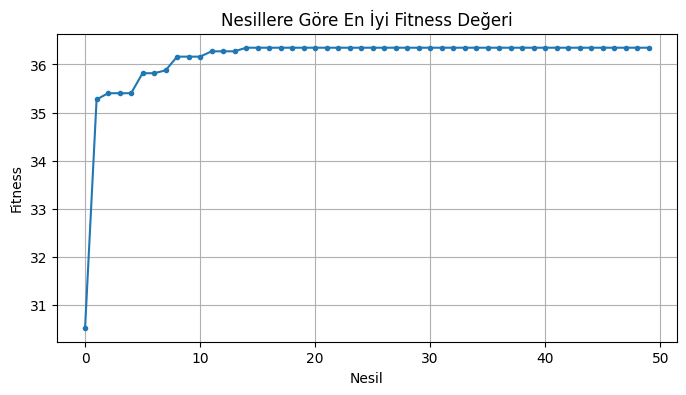

In [16]:
# Fitness grafiği
plt.figure(figsize=(8,4))
plt.plot(best_fitness_history, marker="o", markersize=3)
plt.title("Nesillere Göre En İyi Fitness Değeri")
plt.xlabel("Nesil")
plt.ylabel("Fitness")
plt.grid(True)
plt.show()


# **14) Sonuçların Grafiksel Analizi ve Yorumlanması**

Bu hücrede genetik algoritmanın çalışma süreci ve sonuçları grafikler aracılığıyla analiz edilir. Grafikler, sayısal çıktılara kıyasla algoritmanın davranışını daha sezgisel biçimde yorumlamaya olanak tanır.

Bu kapsamda iki temel analiz yapılır: En iyi fitness değerinin nesillere göre değişimi, algoritmanın zamanla daha iyi çözümler bulup bulmadığını gösterir. Fitness değerinde genel bir artış eğilimi, yöntemin başarılı çalıştığını ifade eder. x1 ve x2 değerlerinin nesillere göre değişimi ise algoritmanın hangi çalışma saatlerine doğru yakınsadığını ortaya koyar ve çözümün anlamlı bir dengeye ulaşıp ulaşmadığını gösterir.

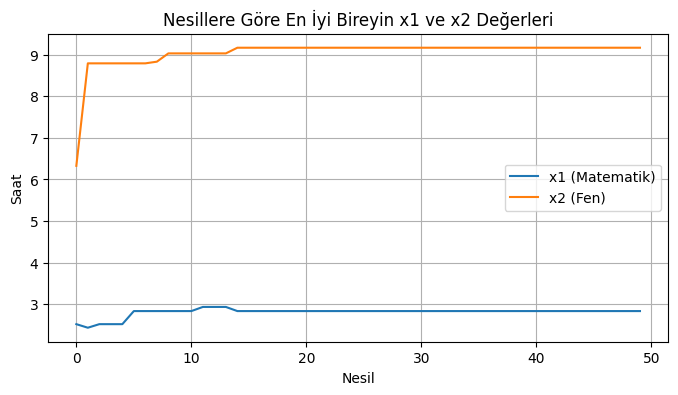

In [17]:
# x1 ve x2 aynı grafikte
plt.figure(figsize=(8,4))
plt.plot(best_x1_history, label="x1 (Matematik)")
plt.plot(best_x2_history, label="x2 (Fen)")
plt.title("Nesillere Göre En İyi Bireyin x1 ve x2 Değerleri")
plt.xlabel("Nesil")
plt.ylabel("Saat")
plt.grid(True)
plt.legend()
plt.show()


# YORUM
Bu çalışmada genetik algoritma kullanılarak öğrencinin matematik (x₁) ve fen (x₂) etüt sürelerinin optimize edilmesi amaçlanmıştır.

Amaç fonksiyonu, çalışma süresinin başarı üzerindeki olumlu etkisini ve aşırı çalışmanın verim düşürücü etkisini birlikte modellemektedir.

Başlangıç popülasyonu, x₁ ve x₂ değişkenleri için belirlenen aralıklar içinde rastgele oluşturulmuştur.

Fitness değeri hesaplanırken kısıt ihlalleri ceza yöntemi ile ele alınmış, böylece kısıtlara uymayan bireylerin seçilme olasılığı azaltılmıştır.

Seçim aşamasında rulet tekerleği yöntemi kullanılmış, tek noktalı çaprazlama ve mutasyon işlemleri ile yeni bireyler üretilmiştir. Ayrıca elitizm yöntemi ile her neslin en iyi bireyi korunmuştur.


## SONUÇ
Genetik algoritma sonucunda başarı skorunu maksimize eden uygun etüt süreleri elde edilmiştir. Nesiller ilerledikçe en iyi fitness değerinin arttığı ve belirli bir noktadan sonra kararlı hale geldiği gözlemlenmiştir.

En iyi çözümde matematik etüt süresi (x₁), fen etüt süresi ise (x₂) olarak bulunmaktadır. Bu çözüm, x₁ + x₂ ≤ 12 ve x₂ ≥ 2 kısıtlarını sağlamaktadır.

Sonuç olarak genetik algoritma yöntemi kısıtlı optimizasyon problemlerinde etkili ve uygulanabilir bir çözüm yaklaşımı sunmaktadır.